In [1]:
#Workbench imports
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path

In [3]:
from ema_workbench import load_results

target = Path("temp","experiments")
experiments, outcomes = load_results(target / "2021_2_23_EMA_experiments_five_hundred.tar.gz")
experiments2 = experiments.drop(['policy','model'],axis=1)
experiments2.tail()

,Housing_market,SLR,implementation_time,transient,Mayor,scenario
395995,rational,1,4,SurgeHeight\five_hundred\five_hundred_430.csv,Lawkeeper,98995
395996,rational,3,13,SurgeHeight\five_hundred\five_hundred_453.csv,Lawkeeper,98996
395997,boundedly_rational,3,10,SurgeHeight\five_hundred\five_hundred_157.csv,Lawkeeper,98997
395998,boundedly_rational,5,11,SurgeHeight\five_hundred\five_hundred_32.csv,Lawkeeper,98998
395999,rational,6,4,SurgeHeight\five_hundred\five_hundred_308.csv,Lawkeeper,98999


### Some preprocessing to make plots more appealing

In [4]:
experiments3 = experiments2.copy()

map_house_market = {'rational' : '1', 
             'boundedly_rational' :'0'}

map_house_market_invert = {'1':'R', 
                           '0':'BR'}

map_mayor = {'H. Economicus': '2',
             'Sentiment' : '1',
             'R. Active' : '0',
             'Lawkeeper' : '3'}

map_mayor_invert = { '2' : 'Economic',
                    '1' : 'Sentiment',
                    '0' : 'Reactive',
                    '3' : 'Proactive'
                    }


rename_cols = {'Housing_market' : 'Housing market (R1)',
               'SLR' : 'SLR scenario (X1)',
               'implementation_time' : 'Implementation time (X3)',
               'transient' : 'Transient storm surge (X2)',
               'Mayor' : 'Management strategy (L1)'}

experiments3['Housing_market'].replace(map_house_market,inplace=True)
experiments3['Mayor'].replace(map_mayor,inplace=True)
experiments3['transient'] = experiments3['transient'].apply(lambda s : int(s.split('_')[-1].split('.')[0]))
cols_convert = ['transient', 'implementation_time']
experiments3[cols_convert] = experiments3[cols_convert].astype('int')
experiments3 = experiments3.rename(columns=rename_cols)
experiments3.head()

,Housing market (R1),SLR scenario (X1),Implementation time (X3),Transient storm surge (X2),Management strategy (L1),scenario
0,0,4,12,119,0,0
1,0,4,14,90,0,1
2,0,2,10,220,0,2
3,0,9,9,141,0,3
4,1,5,13,7,0,4


In [5]:
experiments3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 396000 entries, 0 to 395999
Data columns (total 6 columns):
 #   Column                      Non-Null Count   Dtype   
---  ------                      --------------   -----   
 0   Housing market (R1)         396000 non-null  object  
 1   SLR scenario (X1)           396000 non-null  category
 2   Implementation time (X3)    396000 non-null  int32   
 3   Transient storm surge (X2)  396000 non-null  int32   
 4   Management strategy (L1)    396000 non-null  object  
 5   scenario                    396000 non-null  category
dtypes: category(2), int32(2), object(2)
memory usage: 14.2+ MB


In [26]:
remap = {"Area_A_HousePrice_2200":"HP_hp_2200",
         "Area_A_timing_SETP":"HP_first_SETP",
         "Area_B_HousePrice_2200":"CC_hp_2200",
         "Area_B_timing_SETP":"CC_first_SETP"}


outcomes2 = {}
for newlabel, oldlabel in remap.items():
    outcomes2[newlabel] = outcomes[oldlabel]

In [27]:
outcomes2

{'Area_A_HousePrice_2200': array([0, 0, 0, ..., 0, 0, 0], dtype=int64),
 'Area_A_timing_SETP': array([2081, 2080, 2040, ..., 2051, 2055, 9999], dtype=int64),
 'Area_B_HousePrice_2200': array([282357.9820158 , 286542.15584763,      0.        , ...,
        350017.41980036, 350036.70600789, 350040.12775439]),
 'Area_B_timing_SETP': array([2096, 2125, 2106, ..., 9999, 9999, 9999], dtype=int64)}

# Feature scoring
### Regression 
The timing_SETP is set to 9999 if there is no tipping point in any of the years (<2300)

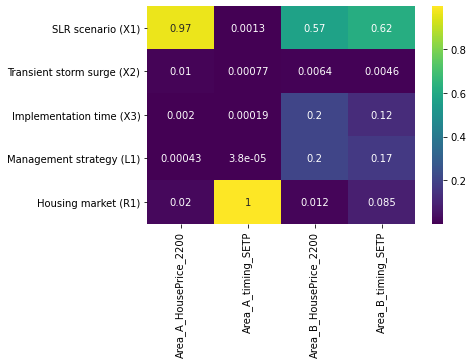

In [28]:
from ema_workbench.analysis import feature_scoring
import seaborn as sns

x = experiments3
y = outcomes2

preferred_order = ['SLR scenario (X1)',
                   'Transient storm surge (X2)',
                   'Implementation time (X3)',
                   'Management strategy (L1)',
                   'Housing market (R1)']                   

fs = feature_scoring.get_feature_scores_all(x, y)
fs = fs.reindex(preferred_order)
sns.heatmap(fs, cmap='viridis', annot=True)
plt.show()

The timing_SETP is set to 2500 if there is no tipping point in any of the years (<2300)

In [42]:
import numpy as np
outcomes3=outcomes2.copy()
for key, values in outcomes2.items():
    if key in ["Area_A_timing_SETP","Area_B_timing_SETP"]:
        outcomes3[key] = np.array([2500 if y == 9999 else y for y in values])
outcomes3

{'Area_A_HousePrice_2200': array([0, 0, 0, ..., 0, 0, 0], dtype=int64),
 'Area_A_timing_SETP': array([2081, 2080, 2040, ..., 2051, 2055, 2500], dtype=int64),
 'Area_B_HousePrice_2200': array([282357.9820158 , 286542.15584763,      0.        , ...,
        350017.41980036, 350036.70600789, 350040.12775439]),
 'Area_B_timing_SETP': array([2096, 2125, 2106, ..., 2500, 2500, 2500], dtype=int64)}

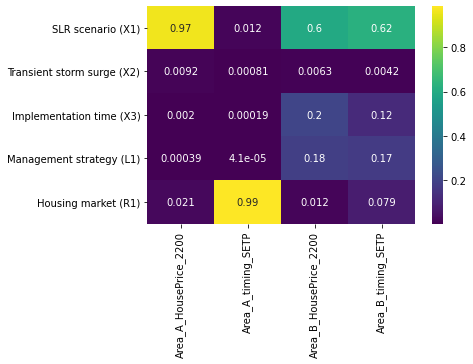

In [45]:
x = experiments3
y = outcomes3

preferred_order = ['SLR scenario (X1)',
                   'Transient storm surge (X2)',
                   'Implementation time (X3)',
                   'Management strategy (L1)',
                   'Housing market (R1)']                   

fs = feature_scoring.get_feature_scores_all(x, y)
fs = fs.reindex(preferred_order)
sns.heatmap(fs, cmap='viridis', annot=True)
plt.show()

Timing set to 2300

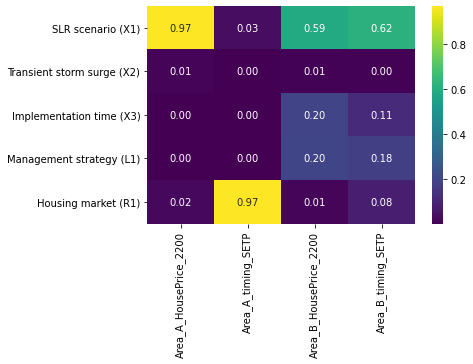

In [55]:
import numpy as np
outcomes4=outcomes2.copy()
for key, values in outcomes2.items():
    if key in ["Area_A_timing_SETP","Area_B_timing_SETP"]:
        outcomes4[key] = np.array([2300 if y == 9999 else y for y in values])
        
x = experiments3
y = outcomes4

preferred_order = ['SLR scenario (X1)',
                   'Transient storm surge (X2)',
                   'Implementation time (X3)',
                   'Management strategy (L1)',
                   'Housing market (R1)']                   

fig, ax = plt.subplots()

fs = feature_scoring.get_feature_scores_all(x, y)
fs = fs.reindex(preferred_order)
ax = sns.heatmap(fs, cmap='viridis', annot=True,fmt='.2f')

In [58]:
from datetime import datetime
today = datetime.date(datetime.now())
date = "{}_{}_{}".format(today.year,today.month,today.day)
target = Path('Visualisations') / date

if not Path.exists(target): Path.mkdir(target)

fig.savefig((target / "FeatureScoring_regression_EMA_2021_2_23.png"),bbox_inches="tight",dpi=200)